In [1]:
import numpy as np
from datetime import date
import calendar
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector, Input, LSTMCell, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow_addons.seq2seq.sampler import (TrainingSampler, GreedyEmbeddingSampler,
    ScheduledEmbeddingTrainingSampler, SampleEmbeddingSampler)
from tensorflow_addons.seq2seq.basic_decoder import BasicDecoder

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Sequential API
### i. A basic seq2seq model

In [3]:
def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [dt.strftime("%B %d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [4]:
MONTHS = calendar.month_name[1:13]
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [5]:
OUTPUT_CHARS = "0123456789-"

In [6]:
def date_str_to_ids(date_str, chars):
    return [chars.index(c) for c in date_str]

In [7]:
def prepare_date_strs(date_strs, chars):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor()

In [8]:
def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [9]:
X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)

In [10]:
embedding_size = 32
max_input_length = X_train.shape[1]
max_output_length = Y_train.shape[1]

In [11]:
encoder = Sequential([
    Embedding(input_dim=len(INPUT_CHARS) + 1,
              output_dim=embedding_size,
              input_shape=[None]),
    LSTM(128)
])

decoder = Sequential([
    LSTM(128, return_sequences=True),
    Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = Sequential([
    encoder,
    RepeatVector(max_output_length),
    decoder
])

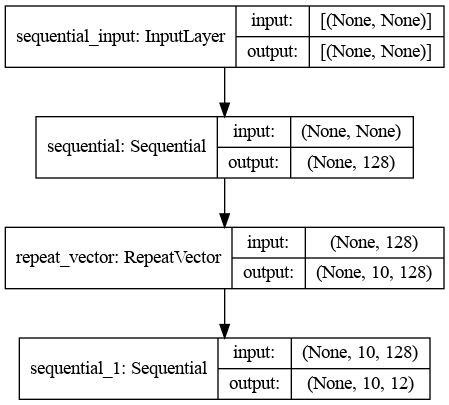

In [12]:
plot_model(model, to_file="Images/model1.png", show_shapes=True)

In [13]:
optimizer = Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 16s 37ms/step - loss: 2.0800 - accuracy: 0.2642 - val_loss: 1.3738 - val_accuracy: 0.4902
Epoch 2/20
313/313 [==============================] - 10s 32ms/step - loss: 1.3406 - accuracy: 0.5092 - val_loss: 1.1213 - val_accuracy: 0.5983
Epoch 3/20
313/313 [==============================] - 9s 29ms/step - loss: 1.0418 - accuracy: 0.6240 - val_loss: 0.9281 - val_accuracy: 0.6535
Epoch 4/20
313/313 [==============================] - 12s 40ms/step - loss: 1.1491 - accuracy: 0.6006 - val_loss: 0.8123 - val_accuracy: 0.6967
Epoch 5/20
313/313 [==============================] - 12s 40ms/step - loss: 0.7371 - accuracy: 0.7225 - val_loss: 0.5998 - val_accuracy: 0.7624
Epoch 6/20
313/313 [==============================] - 13s 41ms/step - loss: 0.8361 - accuracy: 0.7025 - val_loss: 0.5001 - val_accuracy: 0.7970
Epoch 7/20
313/313 [==============================] - 14s 46ms/step - loss: 0.4587 - accuracy: 0.8141 - val_loss: 0.4162 - val_accuracy: 

In [14]:
def ids_to_date_strs(ids, chars):
    return ["".join([chars[index - 1] for index in sequence])
    for sequence in ids]

In [15]:
def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs, INPUT_CHARS)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

In [16]:
def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids, OUTPUT_CHARS)

In [17]:
convert_date_strs(["February 07, 2001"])

['2001-02-07']

## Functional API
### i. Teacher Forcing

In [18]:
sos_id = len(OUTPUT_CHARS) + 1

In [19]:
def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

In [21]:
X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)

In [22]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

In [23]:
encoder_input = Input(shape=[None], dtype=tf.int32)
encoder_embedding = Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size
)(encoder_input)

_, encoder_state_h, encoder_state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=[None], dtype=tf.int32)
decoder_embedding = Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size
)(decoder_input)
decoder_lstm_output = LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state
)
decoder_output = Dense(len(OUTPUT_CHARS) + 1, activation="softmax")(decoder_lstm_output)

model = Model(
    inputs=[encoder_input, decoder_input],
    outputs=[decoder_output]
)

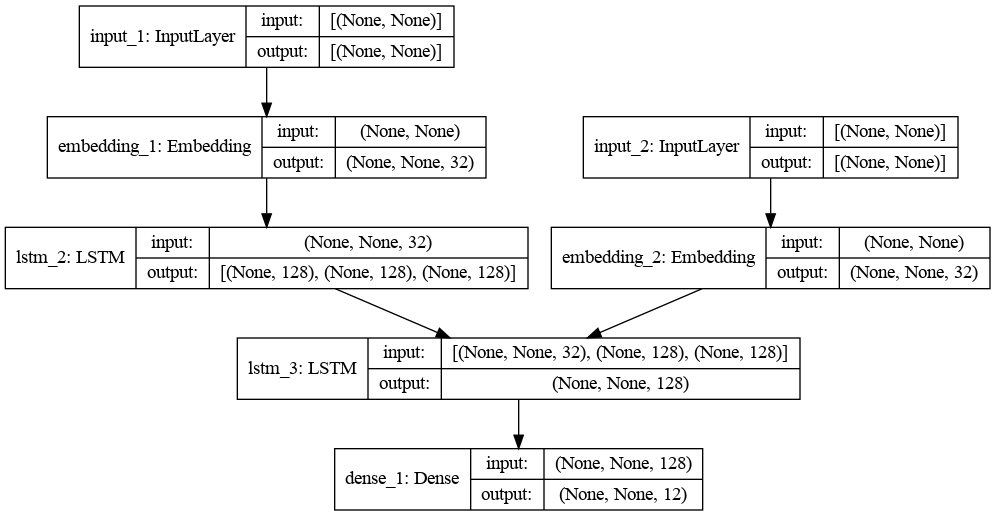

In [24]:
plot_model(model, to_file="Images/model2.png", show_shapes=True)

In [25]:
optimizer = Nadam()
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)
history = model.fit(
    [X_train, X_train_decoder], Y_train, epochs=10,
    validation_data=([X_valid, X_valid_decoder], Y_valid)
)

Epoch 1/10
313/313 [==============================] - 17s 40ms/step - loss: 1.9421 - accuracy: 0.3054 - val_loss: 1.4051 - val_accuracy: 0.4588
Epoch 2/10
313/313 [==============================] - 11s 36ms/step - loss: 1.2992 - accuracy: 0.5145 - val_loss: 0.9309 - val_accuracy: 0.6507
Epoch 3/10
313/313 [==============================] - 12s 37ms/step - loss: 0.8007 - accuracy: 0.7075 - val_loss: 0.4234 - val_accuracy: 0.8661
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3188 - accuracy: 0.9053 - val_loss: 0.1763 - val_accuracy: 0.9565
Epoch 5/10
313/313 [==============================] - 14s 43ms/step - loss: 0.1599 - accuracy: 0.9656 - val_loss: 0.0497 - val_accuracy: 0.9962
Epoch 6/10
313/313 [==============================] - 13s 41ms/step - loss: 0.0512 - accuracy: 0.9952 - val_loss: 0.0502 - val_accuracy: 0.9958
Epoch 7/10
313/313 [==============================] - 13s 42ms/step - loss: 0.0288 - accuracy: 0.9991 - val_loss: 0.0171 - val_accuracy:

In [26]:
def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:], OUTPUT_CHARS)

In [27]:
predict_date_strs(["February 07, 2001"])

['2001-02-07']

### ii. TF-Addons's seq2seq with
### a. Training Sampler (training) + Decoder (inference)

In [28]:
encoder_inputs = Input(shape=[None], dtype=np.int32)
decoder_inputs = Input(shape=[None], dtype=np.int32)
sequence_lengths = Input(shape=[], dtype=np.int32)

encoder_embeddings = Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = TrainingSampler()

decoder_cell = LSTMCell(lstm_units)
output_layer = Dense(len(OUTPUT_CHARS) + 1)

decoder = BasicDecoder(decoder_cell, sampler,
                       output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = Activation("softmax")(final_outputs.rnn_output)

model = Model(inputs=[encoder_inputs, decoder_inputs],
              outputs=[Y_proba])

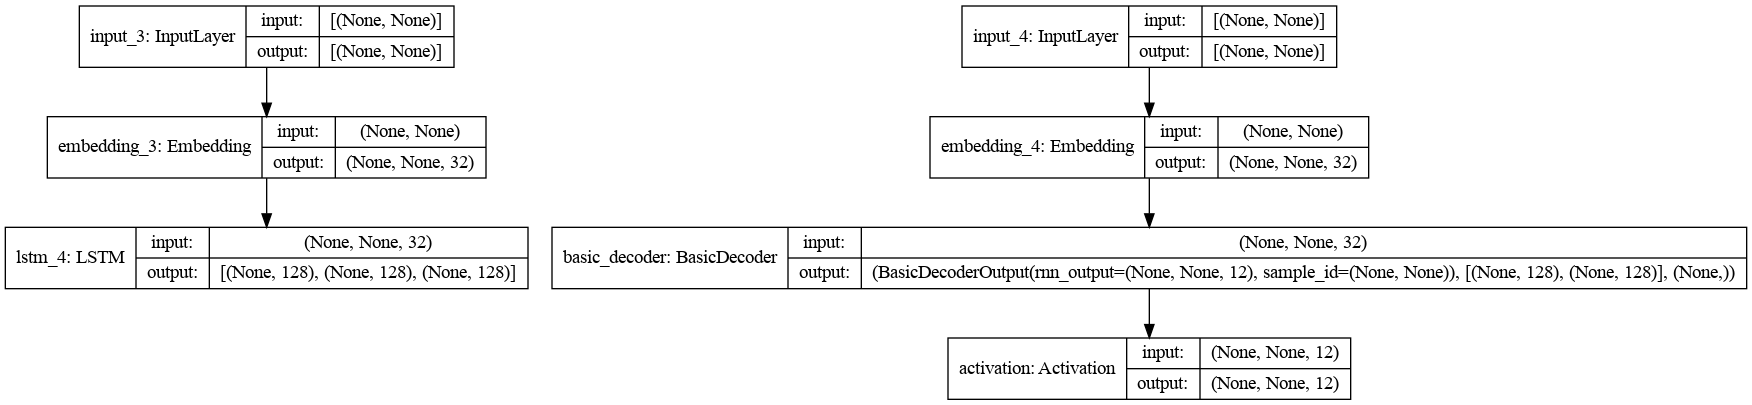

In [29]:
plot_model(model, to_file="Images/model3.png", show_shapes=True)

In [30]:
optimizer = Nadam()
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 13s 29ms/step - loss: 1.9475 - accuracy: 0.3079 - val_loss: 1.4701 - val_accuracy: 0.4281
Epoch 2/15
313/313 [==============================] - 9s 28ms/step - loss: 1.4095 - accuracy: 0.4499 - val_loss: 1.0940 - val_accuracy: 0.5845
Epoch 3/15
313/313 [==============================] - 9s 27ms/step - loss: 0.9916 - accuracy: 0.6337 - val_loss: 0.5429 - val_accuracy: 0.8167
Epoch 4/15
313/313 [==============================] - 7s 23ms/step - loss: 0.4641 - accuracy: 0.8479 - val_loss: 0.1732 - val_accuracy: 0.9721
Epoch 5/15
313/313 [==============================] - 8s 24ms/step - loss: 0.1383 - accuracy: 0.9799 - val_loss: 0.0613 - val_accuracy: 0.9967
Epoch 6/15
313/313 [==============================] - 8s 26ms/step - loss: 0.0453 - accuracy: 0.9984 - val_loss: 0.0272 - val_accuracy: 0.9997
Epoch 7/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0228 - accuracy: 0.9996 - val_loss: 0.3923 - val_accuracy: 0.853

In [31]:
predict_date_strs(["February 07, 2001"])

['2001-02-07']

### b. Training Sampler (training) + Greedy Embedding Sampler (inference)

In [32]:
inference_sampler = GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = Model(inputs=[encoder_inputs],
                        outputs=[final_outputs.sample_id])

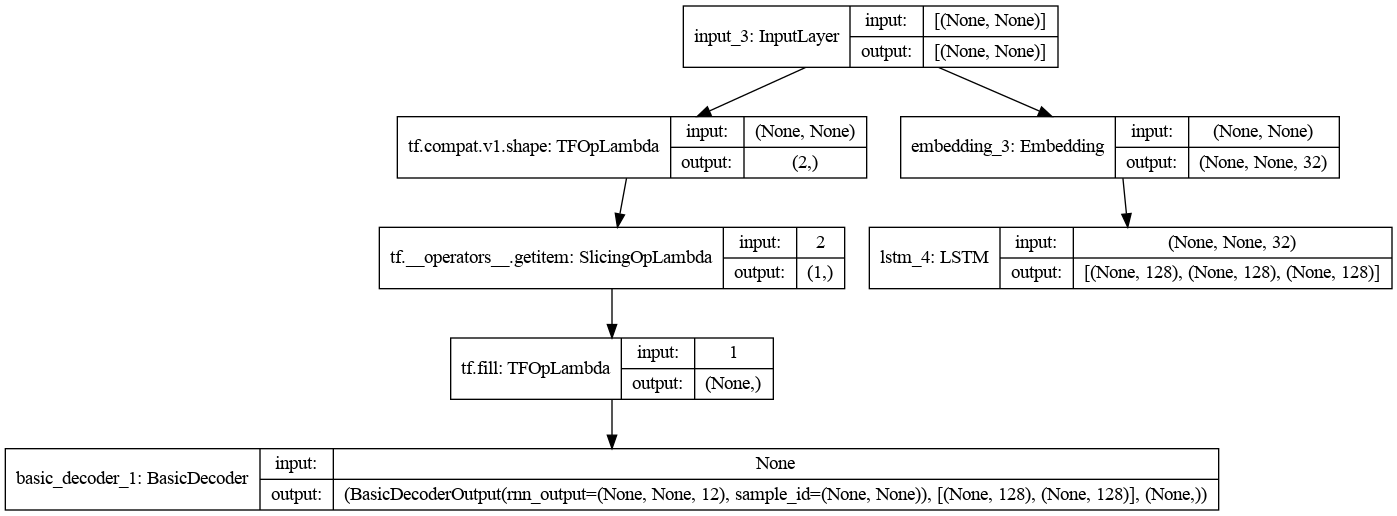

In [34]:
plot_model(inference_model, to_file="Images/model4.png", show_shapes=True)

In [35]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred, OUTPUT_CHARS)

In [36]:
fast_predict_date_strs(["February 07, 2001"])

['2001-02-07']

In [37]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])   

549 ms ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
48.8 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### c. Scheduled Sampler (training) + Scheduled Embedding Sampler (inference)

In [38]:
def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

In [39]:
n_epochs = 20

encoder_inputs = Input(shape=[None], dtype=np.int32)
decoder_inputs = Input(shape=[None], dtype=np.int32)
sequence_lengths = Input(shape=[], dtype=np.int32)

encoder_embeddings = Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = LSTMCell(lstm_units)
output_layer = Dense(len(OUTPUT_CHARS) + 1)

decoder = BasicDecoder(decoder_cell, sampler,
                       output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = Activation("softmax")(final_outputs.rnn_output)

model = Model(inputs=[encoder_inputs, decoder_inputs],
              outputs=[Y_proba])

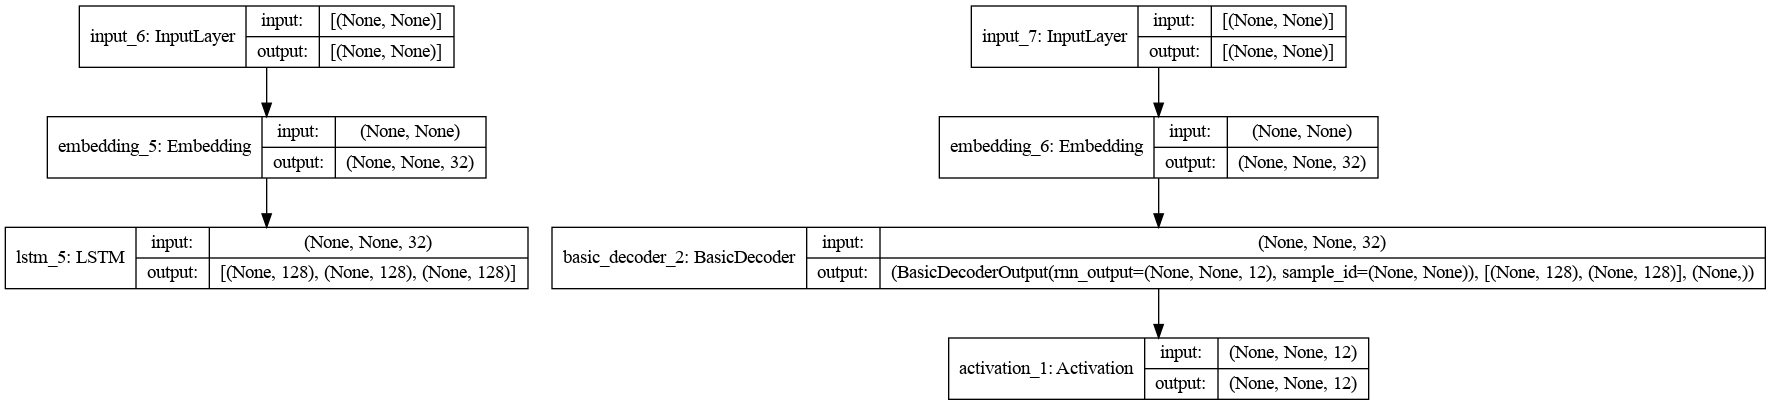

In [40]:
plot_model(model, to_file="Images/model5.png", show_shapes=True)

In [41]:
optimizer = Nadam()
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

sampling_probability_cb = LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20
313/313 [==============================] - 14s 33ms/step - loss: 1.9278 - accuracy: 0.3072 - val_loss: 1.4406 - val_accuracy: 0.4348
Epoch 2/20
313/313 [==============================] - 9s 29ms/step - loss: 1.3665 - accuracy: 0.4622 - val_loss: 1.0687 - val_accuracy: 0.5986
Epoch 3/20
313/313 [==============================] - 9s 28ms/step - loss: 0.9977 - accuracy: 0.6219 - val_loss: 0.7010 - val_accuracy: 0.7404
Epoch 4/20
313/313 [==============================] - 9s 27ms/step - loss: 0.6400 - accuracy: 0.7713 - val_loss: 0.3982 - val_accuracy: 0.8703
Epoch 5/20
313/313 [==============================] - 8s 27ms/step - loss: 0.3624 - accuracy: 0.8819 - val_loss: 0.2383 - val_accuracy: 0.9352
Epoch 6/20
313/313 [==============================] - 9s 27ms/step - loss: 0.2030 - accuracy: 0.9455 - val_loss: 0.1533 - val_accuracy: 0.9646
Epoch 7/20
313/313 [==============================] - 9s 27ms/step - loss: 0.1156 - accuracy: 0.9740 - val_loss: 0.0701 - val_accuracy: 0.985

In [42]:
softmax_temperature = tf.Variable(1.)

inference_sampler = SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = Model(inputs=[encoder_inputs],
                        outputs=[final_outputs.sample_id])

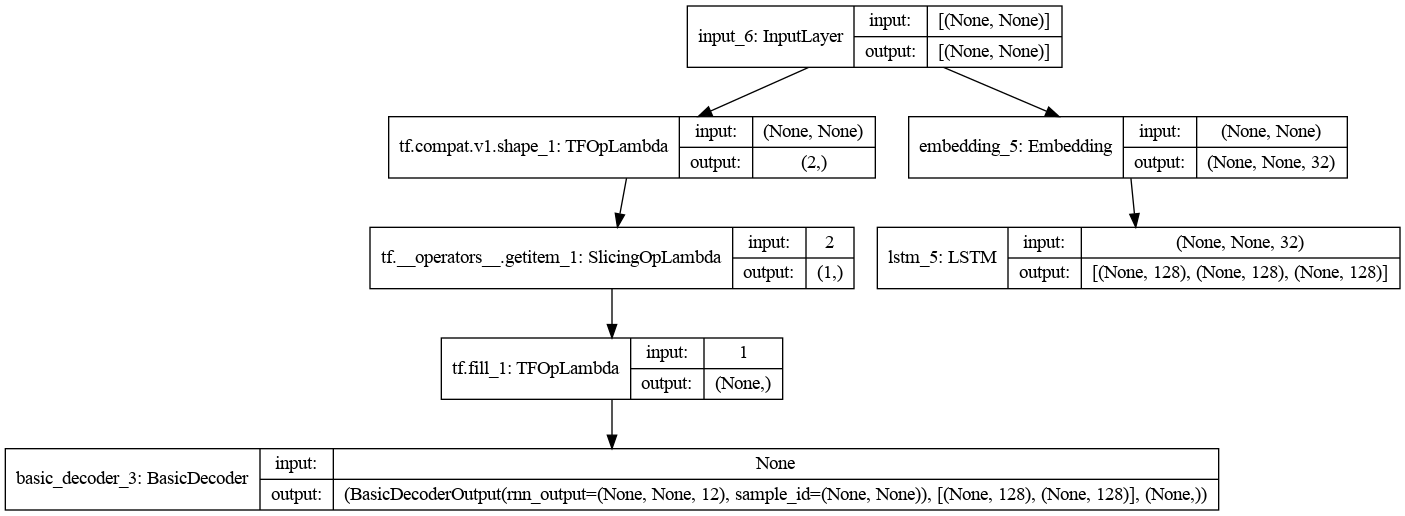

In [43]:
plot_model(inference_model, to_file="Images/model6.png", show_shapes=True)

In [44]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred, OUTPUT_CHARS)

In [45]:
creative_predict_date_strs(["February 07, 2001"])

['2001-02-07']

In [46]:
creative_predict_date_strs(["February 07, 2001"], temperature=5.)

['2030-02907']